<a href="https://colab.research.google.com/github/wanwanliang/Image_Processing_and_Deep_Learning/blob/master/code/WSR_ImageProcessing_StatsML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare environment and data

In [ ]:
!pip install geopandas
!pip install rasterio

In [ ]:
import google.colab
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import rasterio as rio
from google.colab import drive
import tensorflow as tf
import glob
%matplotlib inline
from matplotlib import mlab 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import PIL as pil
from skimage import filters
from scipy.stats import describe

## Set work dir

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr')

In [ ]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45/MCARI2')

## List all files

In [ ]:
tifs = glob.glob('*.tif')

In [ ]:
len(tifs)

In [ ]:
tifs[:5]

# Image exploring

## Histogram plot and percentile plot

In [ ]:
img = rio.open(tifs[0])
arys = img.read()
arys2 = np.moveaxis(arys, 0, -1)
arys2.shape

In [ ]:
arys3 = arys2.reshape((-1,1))
arys3.shape

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(arys3, bins=20)
plt.show()

In [ ]:
hist, bins = np.histogram(arys3, bins=20)
width = 0.7*(bins[1]-bins[0])
center = (bins[:-1]+bins[1:])/2
plt.bar(center, hist,align='center',width=width)
plt.show()

In [ ]:
pdd = pd.DataFrame(arys3)
print(pdd.head(5))
pdd.describe()

In [ ]:
import scipy.stats

# 100 values from a normal distribution with a std of 3 and a mean of 0.5
data = arys3[:,0]
counts, start, dx, _ = scipy.stats.cumfreq(data, numbins=20)
x = np.arange(counts.size) * dx + start
freq = counts/len(arys3[:,0])
plt.plot(x, freq, 'ro')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')

plt.show()

In [ ]:
kwargs={'cumulative':True}
sns.distplot(arys3[:,0], hist_kws=kwargs, kde_kws=kwargs)

In [ ]:
p = np.array([0.0,2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 90.0, 95.0, 97.5, 100.0])
perc = np.percentile(arys3, p)
perc

## Exploring image thresholding

In [ ]:
from skimage.filters import try_all_threshold
import skimage.filters as filters

fig, ax = try_all_threshold(arys2.reshape((30,31)), figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
lst = ['otsu','li','yen','isodata','mean']

mint= min_threshold(arys2.reshape((30,31)), lst)

In [ ]:
binary = arys2.reshape((30,31)) > mint
plt.imshow(binary)
plt.show()

In [ ]:
template = img
ary2tif(binary, img, 'ts.tif')

# Image thresholding

## Define functions

### Image thresholding function

In [ ]:
def img_threshold(img, method=None):
  if method=='otsu':
    thre = filters.threshold_otsu(img)
  if method=='li':
    thre = filters.threshold_li(img)
  if method=='yen':
    thre = filters.threshold_yen(img)
  if method=='isodata':
    thre = filters.threshold_isodata(img)
  if method=='mean':
    thre = filters.threshold_mean(img)
    
  return(thre)

### Get minimum threshold

In [ ]:
def min_threshold(img, method_list):
  thre = []
  for method in lst:
    thre.append(img_threshold(img, method))

  return(min(thre))

### Image array to geotiff

In [ ]:
def ary2tif(img, img_template, nm):
  img = img.astype('float32')
  meta = img_template.meta.copy()
  #meta.update({'nodata': 999, 'dtype': 'float32', 'count':1})


  with rio.open(nm, 'w', **meta) as outf:
    outf.write(img, 1)

### Geotiff to numpy array

In [ ]:
def tif2ary(tif):

  raA = rio.open(tif)
  arys = raA.read()

  arys= arys.astype('float32')
  arys =np.moveaxis(arys, 0, -1)

  return(arys)

### Get image statistic for unmask region

In [ ]:
def img_stats(img_mlp, vi):

  vi_ary = tif2ary(vi)
  threshold = img_threshold(vi_ary, 'otsu')
  img_binary = vi_ary < threshold 
  img_binary = img_binary.reshape((img_binary.shape[0], img_binary.shape[1]))

  img_ary = tif2ary(img_mlp)
  img_ary[img_binary] = np.nan

  img_ary2 = np.concatenate(img_ary,0)
  
 
  fea_ls = []

  for i in range(img_ary2.shape[1]):
    
    des = describe(img_ary2[:,i], axis=0, nan_policy= 'omit')

    mean = des.mean
    var = des.variance

    fea_ls.append(mean)
    fea_ls.append(var)
  
  return(fea_ls)

In [ ]:
def vis_stats(vi_mlp, vi):

  vi_ary = tif2ary(vi)
  threshold = img_threshold(vi_ary, 'otsu')
  img_binary = vi_ary < threshold 
  img_binary = img_binary.reshape((img_binary.shape[0],img_binary.shape[1]))
  img_binary = np.concatenate(img_binary,0)
  #img_binary = img_binary.reshape((img_binary.shape[0],-1))

  vi_mlp[img_binary] = np.nan

  img_ary2 = vi_mlp
  
 
  fea_ls = []

  for i in range(img_ary2.shape[1]):
    
    des = describe(img_ary2[:,i], axis=0, nan_policy= 'omit')

    mean = des.mean
    var = des.variance

    fea_ls.append(mean)
    fea_ls.append(var)
  
  return(fea_ls)

### Calculate vegetation index

In [ ]:
def cal_vis(img):
  img_ary = tif2ary(img)

  r = img_ary[:,:,0]
  g = img_ary[:,:,1]
  b = img_ary[:,:,2]
  nir = img_ary[:,:,6]
  reg = img_ary[:,:,7]

  r2 = r.reshape((r.shape[0]*r.shape[1],-1))
  g2 = g.reshape((g.shape[0]*g.shape[1],-1))
  b2 = b.reshape((b.shape[0]*b.shape[1],-1))
  nir2 = nir.reshape((nir.shape[0]*nir.shape[1],-1))
  reg2 = reg.reshape((reg.shape[0]*reg.shape[1],-1))

  nv = (nir2-r2)/(nir2+r2)
  sr = nir2/r2
  osavi = 1.16*(nir2-r2)/(nir2+r2+0.16)
  gi = g2/r2
  nri = (g2-r2)/(g2+r2)
  
  arys= np.concatenate((nv,sr,osavi,gi,nri),axis=1)
  return(arys)

# List images

In [ ]:
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45')

In [ ]:
tifs = glob.glob("*.tif")
print(("Number of tifs is {}".format(len(tifs))))
tifs[:5]

Number of tifs is 960


['WSR200_2_DH058_50S_ply1_45.tif',
 'WSR200_2_DH072_30MR_ply7_45.tif',
 'WSR200_2_ROB_25MSS_ply5_45.tif',
 'WSR200_2_DH025_5RMR_ply6_45.tif',
 'WSR200_2_DH121_25MSS_ply3_45.tif']

In [ ]:
vis = glob.glob("./MCARI2/*.tif")
print("Number of VI is {}".format(len(vis)))
vis[:10]

Number of VI is 960


['./MCARI2/WSR200_2_DH058_50S_ply1_45.tif',
 './MCARI2/WSR200_2_Faller_5RMR_ply2_45.tif',
 './MCARI2/WSR200_2_DH121_25MSS_ply3_45.tif',
 './MCARI2/WSR200_2_DH025_5RMR_ply6_45.tif',
 './MCARI2/WSR200_2_DH80_40MSS_ply4_45.tif',
 './MCARI2/WSR200_2_DH153_5R_ply8_45.tif',
 './MCARI2/WSR200_2_ROB_25MSS_ply5_45.tif',
 './MCARI2/WSR200_2_DH072_30MR_ply7_45.tif',
 './MCARI2/WSR200_2_DH035_10RMR_ply29_45.tif',
 './MCARI2/WSR200_2_DH158_30MRMSS_ply28_45.tif']

# Extract mean and variance for each band 

In [ ]:
fea = None

for i in range(len(tifs)):

  mlp = tifs[i]
  vi = './MCARI2/' + mlp

  dt = img_stats(mlp, vi)
  dt = np.asarray(dt)
  dt = dt.reshape((16,-1))

  if fea is None:
    fea = dt
  else:
    fea = np.concatenate((fea, dt),axis=1)

# Extract mean and variance from vegetation index

In [ ]:
fea = None

for i in range(len(tifs)):

  mlp = tifs[i]
  vi = './MCARI2/' + mlp
  vis = cal_vis(mlp)

  dt = vis_stats(vis, vi)
  dt = np.asarray(dt)
  dt = dt.reshape((10,-1))

  if fea is None:
    fea = dt
  else:
    fea = np.concatenate((fea, dt),axis=1)

In [ ]:
fea.shape

(10, 960)

In [ ]:
fea2 = np.transpose(fea)
fea2.shape

(960, 10)

In [ ]:
fea_df = pd.DataFrame(fea2)
print(fea_df.shape)
fea_df.head

(960, 10)


<bound method NDFrame.head of             0         1         2  ...         7         8         9
0    0.615409  0.002284  4.283037  ...  0.014584  0.008424  0.003617
1    0.705190  0.001913  5.931502  ...  0.033378  0.121266  0.005322
2    0.661185  0.001646  4.990535  ...  0.026049  0.088361  0.004602
3    0.758825  0.000776  7.402285  ...  0.025851  0.180645  0.003118
4    0.687366  0.001441  5.492526  ...  0.023648  0.101059  0.003888
..        ...       ...       ...  ...       ...       ...       ...
955  0.703984  0.001071  5.843516  ...  0.010425  0.100549  0.001702
956  0.803891  0.000276  9.272617  ...  0.018602  0.230333  0.001661
957  0.642364  0.001188  4.645264  ...  0.008954  0.058262  0.001756
958  0.780192  0.000651  8.219683  ...  0.009905  0.193652  0.001060
959  0.696993  0.001083  5.680710  ...  0.012209  0.093110  0.002049

[960 rows x 10 columns]>

# Get image ID

In [ ]:
tifs[:10]

['WSR200_2_DH058_50S_ply1_45.tif',
 'WSR200_2_DH072_30MR_ply7_45.tif',
 'WSR200_2_ROB_25MSS_ply5_45.tif',
 'WSR200_2_DH025_5RMR_ply6_45.tif',
 'WSR200_2_DH121_25MSS_ply3_45.tif',
 'WSR200_2_DH153_5R_ply8_45.tif',
 'WSR200_2_Faller_5RMR_ply2_45.tif',
 'WSR200_2_DH80_40MSS_ply4_45.tif',
 'WSR200_2_DH062_10RMR_ply13_45.tif',
 'WSR200_2_Robin_10R_ply21_45.tif']

In [ ]:
nms=[]

[nms.append((txt.split("ply")[1]).split("_")[0]) for txt in tifs]


In [ ]:
print(len(nms))
nms[:5]

960


['1', '7', '5', '6', '3']

In [ ]:
nms2 = np.asarray(nms)
nms2 = nms2.reshape((len(nms),-1))
nms_df = pd.DataFrame(nms2)
print(nms2.shape)
print(nms_df.shape)

(960, 1)
(960, 1)


In [ ]:
nms_df.to_csv('../../nms.csv')

In [ ]:
fea_df['ply_ID']=nms_df

In [ ]:
os.getcwd()

'/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45'

In [ ]:
fea_df.shape

(960, 11)

In [ ]:
fea_df.head(5)

,0,1,2,3,4,5,6,7,8,9,ply_ID
0,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,ply1
1,0.705190,0.001913,5.931502,1.013445,0.818019,0.002575,1.291071,0.033378,0.121266,0.005322,ply7
2,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,ply5
3,0.758825,0.000776,7.402285,0.918385,0.880236,0.001044,1.451844,0.025851,0.180645,0.003118,ply6
4,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,ply3


# Write data

In [ ]:
#fea_df.to_csv("/BandStats.csv", index=False)

In [ ]:
fea_df.to_csv("/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45/VIsStats.csv", index=False)

In [ ]:
os.getcwd()

'/content/drive/My Drive/UMN_Research/Data/wsr/image_200_bb45'

# Load and explore data

### Read data

In [ ]:
os.chdir("/content/drive/My Drive/UMN_Research/Data/wsr")

In [ ]:
dt = pd.read_csv('data.csv')
dt.shape

(960, 31)

In [ ]:
dt.head(5)

,plotID,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X0.1,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,score,resistance_class_4,binary_2,block
0,1,26054.19412,52866618.51,27137.44510,80548746.36,14667.25294,1.589171e+07,2433.612745,557978.0798,1257.693382,158689.7290,1456.209804,143218.4589,112914.0471,1.421580e+09,27501.67451,75384230.79,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,50.0,S,S,2
1,2,25070.41186,37842286.10,31685.62109,84783325.68,15492.49259,1.676155e+07,2612.958608,526833.6568,1406.612026,170621.2991,1565.959638,171643.2074,146421.5091,1.453161e+09,31807.99012,65577156.25,0.704512,0.001126,5.860475,0.672441,0.817233,0.001515,1.251328,0.019539,0.108141,0.003200,5.0,MR,R,2
2,3,22230.05606,26873360.55,27711.32369,59799946.18,13979.20796,1.316616e+07,2313.010172,528174.2624,1237.74288,176488.4922,1419.730108,169724.9701,122329.3743,1.068322e+09,27098.23870,52039725.92,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,25.0,S,S,2
3,4,18318.64190,14563155.19,23536.30312,37585325.99,11938.37296,7.414469e+06,2124.877043,315337.9990,1145.411961,102229.5704,1322.807114,101101.1512,114833.4978,9.289586e+08,23970.07281,36346660.18,0.718340,0.001541,6.238550,1.001685,0.833273,0.002073,1.272672,0.025078,0.115595,0.004000,40.0,S,S,2
4,5,22268.81983,32827768.94,27141.65455,67524584.21,14028.76694,1.428309e+07,2498.169835,555439.8466,1320.919731,170685.0399,1508.353512,172552.6236,111148.3901,9.671520e+08,26259.21983,51535493.86,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,25.0,S,S,2


### Data cleaning

In [ ]:
dt2=dt
dt2 = dt2.drop(['plotID'],axis=1)
dt2.shape

dt2['class2']=0
dt2['class2'].iloc[(dt2.block==2)|(dt2.block==3)|(dt2.block==6)]=1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
dt2['class2'].value_counts()

1    480
0    480
Name: class2, dtype: int64

In [ ]:
print(dt2.shape)
dt2.head(5)

(960, 31)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X0.1,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,score,resistance_class_4,binary_2,block,class2
0,26054.19412,52866618.51,27137.44510,80548746.36,14667.25294,1.589171e+07,2433.612745,557978.0798,1257.693382,158689.7290,1456.209804,143218.4589,112914.0471,1.421580e+09,27501.67451,75384230.79,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,50.0,S,S,2,1
1,25070.41186,37842286.10,31685.62109,84783325.68,15492.49259,1.676155e+07,2612.958608,526833.6568,1406.612026,170621.2991,1565.959638,171643.2074,146421.5091,1.453161e+09,31807.99012,65577156.25,0.704512,0.001126,5.860475,0.672441,0.817233,0.001515,1.251328,0.019539,0.108141,0.003200,5.0,MR,R,2,1
2,22230.05606,26873360.55,27711.32369,59799946.18,13979.20796,1.316616e+07,2313.010172,528174.2624,1237.74288,176488.4922,1419.730108,169724.9701,122329.3743,1.068322e+09,27098.23870,52039725.92,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,25.0,S,S,2,1
3,18318.64190,14563155.19,23536.30312,37585325.99,11938.37296,7.414469e+06,2124.877043,315337.9990,1145.411961,102229.5704,1322.807114,101101.1512,114833.4978,9.289586e+08,23970.07281,36346660.18,0.718340,0.001541,6.238550,1.001685,0.833273,0.002073,1.272672,0.025078,0.115595,0.004000,40.0,S,S,2,1
4,22268.81983,32827768.94,27141.65455,67524584.21,14028.76694,1.428309e+07,2498.169835,555439.8466,1320.919731,170685.0399,1508.353512,172552.6236,111148.3901,9.671520e+08,26259.21983,51535493.86,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,25.0,S,S,2,1


In [ ]:
dt3 = dt2
dt3 = dt3.drop(['score','resistance_class_4','binary_2','block'],axis=1)
print(dt3.shape)
dt3.head(5)

(960, 27)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X0.1,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,class2
0,26054.19412,52866618.51,27137.44510,80548746.36,14667.25294,1.589171e+07,2433.612745,557978.0798,1257.693382,158689.7290,1456.209804,143218.4589,112914.0471,1.421580e+09,27501.67451,75384230.79,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,1
1,25070.41186,37842286.10,31685.62109,84783325.68,15492.49259,1.676155e+07,2612.958608,526833.6568,1406.612026,170621.2991,1565.959638,171643.2074,146421.5091,1.453161e+09,31807.99012,65577156.25,0.704512,0.001126,5.860475,0.672441,0.817233,0.001515,1.251328,0.019539,0.108141,0.003200,1
2,22230.05606,26873360.55,27711.32369,59799946.18,13979.20796,1.316616e+07,2313.010172,528174.2624,1237.74288,176488.4922,1419.730108,169724.9701,122329.3743,1.068322e+09,27098.23870,52039725.92,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,1
3,18318.64190,14563155.19,23536.30312,37585325.99,11938.37296,7.414469e+06,2124.877043,315337.9990,1145.411961,102229.5704,1322.807114,101101.1512,114833.4978,9.289586e+08,23970.07281,36346660.18,0.718340,0.001541,6.238550,1.001685,0.833273,0.002073,1.272672,0.025078,0.115595,0.004000,1
4,22268.81983,32827768.94,27141.65455,67524584.21,14028.76694,1.428309e+07,2498.169835,555439.8466,1320.919731,170685.0399,1508.353512,172552.6236,111148.3901,9.671520e+08,26259.21983,51535493.86,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,1


### Check NaN 

In [ ]:
pd.isnull(dt3).any(axis=0)

X0        False
X1        False
X2        False
X3        False
X4        False
X5        False
X6        False
X7        False
X8        False
X9         True
X10       False
X11        True
X12       False
X13       False
X14       False
X15       False
X0.1      False
X1.1      False
X2.1      False
X3.1      False
X4.1      False
X5.1      False
X6.1      False
X7.1      False
X8.1      False
X9.1      False
class2    False
dtype: bool

In [ ]:
pd.isnull(dt3).sum(axis=0)

X0        0
X1        0
X2        0
X3        0
X4        0
X5        0
X6        0
X7        0
X8        0
X9        1
X10       0
X11       1
X12       0
X13       0
X14       0
X15       0
X0.1      0
X1.1      0
X2.1      0
X3.1      0
X4.1      0
X5.1      0
X6.1      0
X7.1      0
X8.1      0
X9.1      0
class2    0
dtype: int64

In [ ]:
dt4 = dt3.dropna(axis=0)
print(dt4.shape)

(959, 27)


In [ ]:
dt4.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X0.1,X1.1,X2.1,X3.1,X4.1,X5.1,X6.1,X7.1,X8.1,X9.1,class2
0,26054.19412,52866618.51,27137.44510,80548746.36,14667.25294,1.589171e+07,2433.612745,557978.0798,1257.693382,158689.7290,1456.209804,143218.4589,112914.0471,1.421580e+09,27501.67451,75384230.79,0.615409,0.002284,4.283037,0.453224,0.713874,0.003074,1.024282,0.014584,0.008424,0.003617,1
1,25070.41186,37842286.10,31685.62109,84783325.68,15492.49259,1.676155e+07,2612.958608,526833.6568,1406.612026,170621.2991,1565.959638,171643.2074,146421.5091,1.453161e+09,31807.99012,65577156.25,0.704512,0.001126,5.860475,0.672441,0.817233,0.001515,1.251328,0.019539,0.108141,0.003200,1
2,22230.05606,26873360.55,27711.32369,59799946.18,13979.20796,1.316616e+07,2313.010172,528174.2624,1237.74288,176488.4922,1419.730108,169724.9701,122329.3743,1.068322e+09,27098.23870,52039725.92,0.687366,0.001441,5.492526,0.629666,0.797343,0.001940,1.235449,0.023648,0.101059,0.003888,1
3,18318.64190,14563155.19,23536.30312,37585325.99,11938.37296,7.414469e+06,2124.877043,315337.9990,1145.411961,102229.5704,1322.807114,101101.1512,114833.4978,9.289586e+08,23970.07281,36346660.18,0.718340,0.001541,6.238550,1.001685,0.833273,0.002073,1.272672,0.025078,0.115595,0.004000,1
4,22268.81983,32827768.94,27141.65455,67524584.21,14028.76694,1.428309e+07,2498.169835,555439.8466,1320.919731,170685.0399,1508.353512,172552.6236,111148.3901,9.671520e+08,26259.21983,51535493.86,0.661185,0.001646,4.990535,0.546901,0.766974,0.002215,1.205786,0.026049,0.088361,0.004602,1


# Train models

In [ ]:
from sklearn.ensemble import BaggingClassifier as bc
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import VotingClassifier as vc
from sklearn.linear_model import LogisticRegression as lrc
from sklearn.svm import SVC as svc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Set train, validation, and test data 

In [ ]:
x, y = dt4.drop(['class2'], axis=1), dt4['class2']

In [ ]:
x = StandardScaler().fit_transform(x)
x.shape

(959, 26)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16, shuffle=True, test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=16, test_size=0.2)

In [ ]:
print("Train size is: {}".format(x_train.shape[0]))
print("Test size is: {}".format(x_test.shape[0]))
print("Validation size is: {}".format(x_val.shape[0]))

Train size is: 652
Test size is: 144
Validation size is: 163


### RF and SVM Models

In [ ]:
rf_clf = rfc(n_estimators=500, random_state=42) 
svm_clf = svc(gamma='scale', random_state=42)

In [ ]:
rf_clf.fit(x_train, y_train)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# score - regression

In [ ]:
y_pred_rf = rf_clf.predict(x_test)
y_pred_svm = svm_clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

print("Test Accuracy by RF: {}".format(accuracy_score(y_test, y_pred_rf)))
print("Test Accuracy by SVM: {}".format(accuracy_score(y_test, y_pred_svm)))

Test Accuracy by RF: 0.7708333333333334
Test Accuracy by SVM: 0.75


In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix by RF:")
print(confusion_matrix(y_test, y_pred_rf))

print("")
print("Confusion matrix by SVM:")
print(confusion_matrix(y_test, y_pred_svm))

Confusion matrix by RF:
[[62 15]
 [18 49]]

Confusion matrix by SVM:
[[62 15]
 [21 46]]


### MLP Model

### Build MLP step by step

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
mlp_model = keras.models.Sequential()
mlp_model.add(keras.layers.Dense(50,input_dim = 26, activation='relu'))
mlp_model.add(keras.layers.Dense(20, activation='relu'))
mlp_model.add(keras.layers.Dense(20, activation='relu'))
mlp_model.add(keras.layers.Dense(1, activation='sigmoid'))

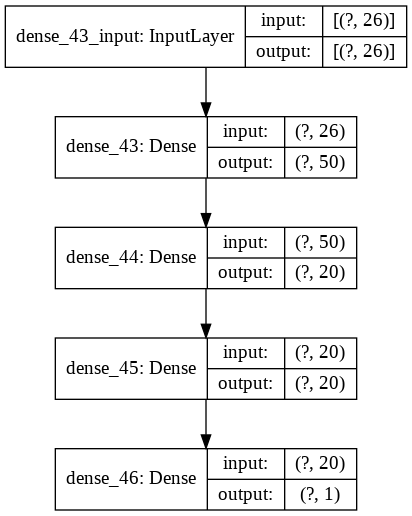

In [ ]:
keras.utils.plot_model(mlp_model, show_shapes=True)

In [ ]:
mlp_model.compile(loss='binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=0.01),
                  metrics=['accuracy'])

In [ ]:
fit_history = mlp_model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0, validation_data=(x_val, y_val))

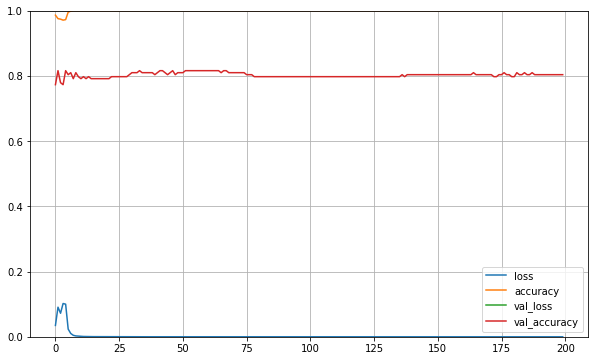

In [ ]:
pd.DataFrame(fit_history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
y_pred_mlp = mlp_model.predict_classes(x_test)
print("Test Accuracy by MLP: {}".format(accuracy_score(y_test, y_pred_mlp)))

Test Accuracy by MLP: 0.7847222222222222


In [ ]:
print("Confusion matrix by MLP:")
print(confusion_matrix(y_test, y_pred_mlp))

Confusion matrix by MLP:
[[62 15]
 [16 51]]


### Build MLP by defined function

In [ ]:
  def build_model(n_hidden=2, n_neuron=30,learning_rate=0.01, input_shape=[26]):

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
      model.add(keras.layers.Dense(n_neuron, activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="binary_crossentropy", metrics=['accuracy'],optimizer=optimizer)

    return model

In [ ]:
keras_cla = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [ ]:
keras_cla.fit(x_train, y_train, epochs=200, batch_size=16, verbose=0, validation_data=(x_val, y_val),callbacks=[keras.callbacks.EarlyStopping(patience=20)])

In [ ]:
keras_cla.score(x_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.5847 - accuracy: 0.8125


0.8125

### Hyperparameter tuning

In [ ]:
import scipy
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {
    'n_hidden':[1,2,3,4],
    'n_neuron':[10,20,30,50],
    'learning_rate':[0.1, 0.01, 0.001],
}

rd_search_cv = RandomizedSearchCV(keras_cla, params, n_iter=10, cv=3, verbose=2)

In [ ]:
rd_search_cv.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[keras.callbacks.EarlyStopping(patience=20)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neuron=50, n_hidden=4, learning_rate=0.01 .....................
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


14/14 [==============================] - 0s 12ms/step - loss: 0.6297 - accuracy: 0.6590 - val_loss: 0.5724 - val_accuracy: 0.7239
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5374 - accuracy: 0.7373 - val_loss: 0.5601 - val_accuracy: 0.7485
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.7350 - val_loss: 0.5521 - val_accuracy: 0.7669
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4882 - accuracy: 0.7650 - val_loss: 0.4885 - val_accuracy: 0.7546
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4588 - accuracy: 0.7811 - val_loss: 0.5228 - val_accuracy: 0.6994
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4699 - accuracy: 0.7696 - val_loss: 0.4879 - val_accuracy: 0.8037
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.4375 - accuracy: 0.7995 - val_loss: 0.4394 - val_accuracy: 0.8098
Epoch 8/100
14/14 [=====

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


14/14 [==============================] - 0s 12ms/step - loss: 0.6421 - accuracy: 0.6345 - val_loss: 0.6128 - val_accuracy: 0.6994
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5657 - accuracy: 0.7103 - val_loss: 0.6298 - val_accuracy: 0.6135
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5590 - accuracy: 0.7149 - val_loss: 0.5751 - val_accuracy: 0.7607
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.7609 - val_loss: 0.5209 - val_accuracy: 0.7485
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4644 - accuracy: 0.7586 - val_loss: 0.5545 - val_accuracy: 0.7055
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4667 - accuracy: 0.7793 - val_loss: 0.4604 - val_accuracy: 0.8221
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 0.4343 - accuracy: 0.7931 - val_loss: 0.5000 - val_accuracy: 0.7546
Epoch 8/100
14/14 [=====

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.9min finished


21/21 [==============================] - 0s 7ms/step - loss: 0.6250 - accuracy: 0.6457 - val_loss: 0.5876 - val_accuracy: 0.6687
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5673 - accuracy: 0.7055 - val_loss: 0.5618 - val_accuracy: 0.7055
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5376 - accuracy: 0.7178 - val_loss: 0.5379 - val_accuracy: 0.7055
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7408 - val_loss: 0.5308 - val_accuracy: 0.7301
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.5154 - accuracy: 0.7347 - val_loss: 0.5324 - val_accuracy: 0.7117
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.7623 - val_loss: 0.4847 - val_accuracy: 0.7239
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.4759 - accuracy: 0.7638 - val_loss: 0.4662 - val_accuracy: 0.7485
Epoch 8/100
21/21 [======

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd5b2bf47b8>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001],
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neuron': [10, 20, 30, 50]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
rd_search_cv.best_params_

{'learning_rate': 0.01, 'n_hidden': 2, 'n_neuron': 30}